In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import keras
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum, concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
# from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image


from tqdm import tqdm

In [2]:
path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

test_image_flair=nib.load(path + 'BraTS20_Training_111/BraTS20_Training_111_flair.nii').get_fdata()
test_image_t1=nib.load(path + 'BraTS20_Training_111/BraTS20_Training_111_t1.nii').get_fdata()
test_image_t1ce=nib.load(path + 'BraTS20_Training_111/BraTS20_Training_111_t1ce.nii').get_fdata()
test_image_t2=nib.load(path + 'BraTS20_Training_111/BraTS20_Training_111_t2.nii').get_fdata()
test_mask=nib.load(path + 'BraTS20_Training_111/BraTS20_Training_111_seg.nii').get_fdata()

In [10]:
print(test_image_flair.shape,test_image_t1.shape,test_image_t1ce.shape,test_image_t2.shape,test_mask.shape)
hdr=nib.load(path + 'BraTS20_Training_111/BraTS20_Training_111_flair.nii').header
# hdr = img.header
# print(hdr)

# Get all header data into list.
header = [(_key,hdr[_key]) for _key in hdr]
header

(240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155)


[('sizeof_hdr', array(348, dtype=int32)),
 ('data_type', array(b'', dtype='|S10')),
 ('db_name', array(b'', dtype='|S18')),
 ('extents', array(0, dtype=int32)),
 ('session_error', array(0, dtype=int16)),
 ('regular', array(b'r', dtype='|S1')),
 ('dim_info', array(0, dtype=uint8)),
 ('dim', array([  3, 240, 240, 155,   1,   1,   1,   1], dtype=int16)),
 ('intent_p1', array(0., dtype=float32)),
 ('intent_p2', array(0., dtype=float32)),
 ('intent_p3', array(0., dtype=float32)),
 ('intent_code', array(0, dtype=int16)),
 ('datatype', array(4, dtype=int16)),
 ('bitpix', array(16, dtype=int16)),
 ('slice_start', array(0, dtype=int16)),
 ('pixdim', array([1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)),
 ('vox_offset', array(0., dtype=float32)),
 ('scl_slope', array(nan, dtype=float32)),
 ('scl_inter', array(nan, dtype=float32)),
 ('slice_end', array(0, dtype=int16)),
 ('slice_code', array(0, dtype=uint8)),
 ('xyzt_units', array(2, dtype=uint8)),
 ('cal_max', array(0., dtype=float32)),
 ('cal

Text(0.5, 1.0, 'Mask')

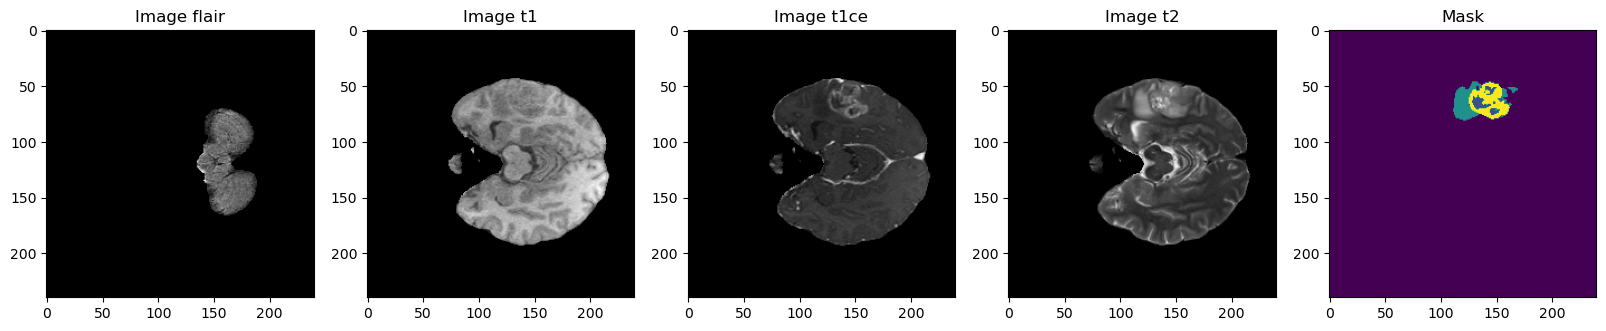

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 51
ax1.imshow(test_image_flair[:,:,10], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,slice_w])
ax5.set_title('Mask')

In [48]:
s = set()
for i in range(155):
    s.add(np.max(test_image_flair[:,:,i]))
s

{0.0,
 168.0,
 198.0,
 216.0,
 234.0,
 241.0,
 250.0,
 271.0,
 282.0,
 284.0,
 306.0,
 315.0,
 320.0,
 325.0,
 332.0,
 340.0,
 350.0,
 362.0,
 371.0,
 379.0,
 387.0,
 389.0,
 393.0,
 394.0,
 401.0,
 403.0,
 410.0,
 411.0,
 413.0,
 417.0,
 418.0,
 421.0,
 424.0,
 430.0,
 432.0,
 437.0,
 441.0,
 443.0,
 449.0,
 451.0,
 458.0,
 467.0,
 469.0,
 473.0,
 474.0,
 477.0,
 481.0,
 485.0,
 491.0,
 493.0,
 495.0,
 497.0,
 499.0,
 500.0,
 502.0,
 504.0,
 505.0,
 506.0,
 509.0,
 510.0,
 511.0,
 512.0,
 515.0,
 517.0,
 520.0,
 521.0,
 524.0,
 525.0,
 526.0,
 528.0,
 530.0,
 531.0,
 542.0,
 543.0,
 544.0,
 547.0,
 548.0,
 550.0,
 553.0,
 554.0,
 555.0,
 559.0,
 560.0,
 563.0,
 565.0,
 572.0,
 573.0,
 579.0,
 587.0,
 588.0,
 591.0,
 600.0,
 601.0,
 602.0,
 604.0,
 606.0,
 609.0,
 613.0,
 615.0,
 620.0,
 622.0,
 623.0,
 628.0,
 638.0,
 640.0,
 649.0,
 656.0,
 670.0,
 671.0,
 687.0,
 690.0,
 696.0,
 748.0,
 762.0}

In [12]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


# define per class evaluation of dice coef

def dice_coef_necrotic(y_true, y_pred, epsilon=0.000001):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=0.000001):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=0.000001):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
# Precision: TP / (TP + FP)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    
# Computing Sensitivity  
# Sensitivity or recall: TP / (TP + FN)
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
# Specificity: TN / (TN + FP)
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [13]:
#  c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
#     p1 = MaxPooling3D((2, 2, 2))(c1)
    
#     c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
#     p2 = MaxPooling3D((2, 2, 2))(c2)
     
#     c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
#     p3 = MaxPooling3D((2, 2, 2))(c3)
     
#     c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
#     p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
#     c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)
    
#     #Expansive path 
#     u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)
     
#     u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)
     
#     u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)
     
#     u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)
     
#     outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
     
#     model = Model(inputs=[inputs], outputs=[outputs])
    
#     return model

In [14]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
  
  return X


# def Unet_3d(input_img, n_filters = 16, dropout = 0.2, batch_norm = True):

#   c1 = conv_block(input_img,n_filters,3,batch_norm)
#   p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
#   p1 = Dropout(dropout)(p1)
  
#   c2 = conv_block(p1,n_filters*2,3,batch_norm);
#   p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
#   p2 = Dropout(dropout)(p2)

#   c3 = conv_block(p2,n_filters*4,3,batch_norm);
#   p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
#   p3 = Dropout(dropout)(p3)
  
#   c4 = conv_block(p3,n_filters*8,3,batch_norm);
#   p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
#   p4 = Dropout(dropout)(p4)
    
#   c5 = conv_block(p4,n_filters*16,3,batch_norm);
#   p5 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c5)
#   p5 = Dropout(dropout)(p5)
  
#   c55 = conv_block(p5,n_filters*32,3,batch_norm);
# #   c55 = conv_block(p4,n_filters*16,3,batch_norm);

#   u66 = Conv3DTranspose(n_filters*16, (3,3,3), strides=(2, 2, 2), padding='same')(c55);
#   u66 = concatenate([u66,c5]);  
#   c66 = conv_block(u66,n_filters*16,3,batch_norm)
#   c66 = Dropout(dropout)(c66)


#   u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c66);
#   u6 = concatenate([u6,c4]);
#   c6 = conv_block(u6,n_filters*8,3,batch_norm)
#   c6 = Dropout(dropout)(c6)
#   u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);

#   u7 = concatenate([u7,c3]);
#   c7 = conv_block(u7,n_filters*4,3,batch_norm)
#   c7 = Dropout(dropout)(c7)
#   u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
#   u8 = concatenate([u8,c2]);

#   c8 = conv_block(u8,n_filters*2,3,batch_norm)
#   c8 = Dropout(dropout)(c8)
#   u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);

#   u9 = concatenate([u9,c1]);

#   c9 = conv_block(u9,n_filters,3,batch_norm)
#   outputs = Conv3D(4, (1, 1,1), activation='softmax')(c9)
# #   print(outputs.shape)  ==> (None, 128, 128, 128, 4)
#   model = Model(inputs=input_img, outputs=outputs)
    
#   return model

def Unet_3d(input_img, n_filters = 16, dropout = 0.2, batch_norm = True):

  c1 = conv_block(input_img,n_filters,3,batch_norm)
  p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_block(p1,n_filters*2,3,batch_norm);
  p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_block(p2,n_filters*4,3,batch_norm);
  p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3,n_filters*8,3,batch_norm);
  p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv_block(p4,n_filters*16,3,batch_norm);

  u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  c6 = Dropout(dropout)(c6)
  u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);

  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  c7 = Dropout(dropout)(c7)
  u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);

  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);

  u9 = concatenate([u9,c1]);

  c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1, 1,1), activation='softmax')(c9)
    
#   print(outputs.shape)
  model = Model(inputs=input_img, outputs=outputs)

  return model



def standardize(image):

  standardized_image = np.zeros(image.shape)

  for z in range(image.shape[2]):
      # get a slice of the image 
      # at channel c and z-th dimension `z`
      image_slice = image[:,:,z]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice)
      
      # divide by the standard deviation (only if it is different from zero)
      if(np.std(centered)!=0):
          centered = centered/np.std(centered) 

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[:, :, z] = centered

  ### END CODE HERE ###

  return standardized_image


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)



In [15]:
# # CallBacks
# import keras
# from keras.callbacks import ModelCheckpoint, CSVLogger

# # Define callback to save model at specific epochs
# checkpoint = ModelCheckpoint('model_{epoch:02d}.h5', monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1, save_freq='epoch')
# epochs_to_save = [10, 20, 30, 40]
# class SaveEpochs(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if epoch + 1 in epochs_to_save:
#             self.model.save(f'model_{epoch+1}.h5')

# # Define callback to log training history
# csv_logger = CSVLogger('training.log')

# # callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),    checkpoint,    SaveEpochs(),    csv_logger]
# callbacks = [checkpoint,csv_logger]

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save model checkpoints

checkpoint_callback = ModelCheckpoint(
    filepath='my_model_checkpoint_{epoch}.h5',
    save_weights_only=False,
    verbose=1
)

# callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),    checkpoint,    SaveEpochs(),    csv_logger]
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1), checkpoint_callback]

In [17]:

def imageLoader(path, folders, batch_size=1, Req=None):

    L = len(folders)
    
    data = np.zeros((240,240,155,4))
    image_data2=np.zeros((240,240,155))

    #keras needs the generator infinite, so we will use while true  
    while True:

        image_num = 0
        batch_end = batch_size

        while image_num < L: # 369 images in total
            limit = min(batch_end, 369)
                
            x = folders[image_num]
            if(Req):
                print("Here "+ Req + " " + x)
            
#             print(x)
            
            folder_path = path + '/' + x;
            modalities = os.listdir(folder_path)
            modalities.sort()
            
            
            w = 0
            for j in range(len(modalities)):
              image_path = folder_path + '/' + modalities[j]
              if(image_path[-7:-1] + image_path[-1] == 'seg.nii'):
                img = nib.load(image_path);
                image_data2 = img.get_fdata()
                image_data2 = np.asarray(image_data2)
              else:
                img = nib.load(image_path);
                image_data = img.get_fdata()
                image_data = np.asarray(image_data)
                image_data = standardize(image_data)
                data[:,:,:,w] = image_data
                w = w+1
            
            reshaped_data=data[56:184,80:208,13:141,:]
    
            reshaped_image_data2=image_data2[56:184,80:208,13:141]
        
        
            reshaped_data=reshaped_data.reshape(1,128,128,128,4)
            reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
            reshaped_image_data2[reshaped_image_data2==4] = 3
            hello = reshaped_image_data2.flatten()
            
            
#             class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(hello),y = hello)

            reshaped_image_data2 = to_categorical(reshaped_image_data2, num_classes = 4)
            
            
                       
            X = reshaped_data
            Y = reshaped_image_data2

            yield (X,Y)    

            image_num += batch_size   
            batch_end += batch_size

In [18]:
from sklearn.model_selection import train_test_split

all_images = os.listdir(path)
all_images.sort()
print(len(all_images))
print(all_images[-5:])
all_images.remove('name_mapping.csv')
all_images.remove('survival_info.csv')

print(os.listdir(path+'BraTS20_Training_355'))
all_images.remove('BraTS20_Training_355')
print(all_images[-5:])

print(len(all_images))

371
['BraTS20_Training_367', 'BraTS20_Training_368', 'BraTS20_Training_369', 'name_mapping.csv', 'survival_info.csv']
['BraTS20_Training_355_flair.nii', 'W39_1998.09.19_Segm.nii', 'BraTS20_Training_355_t2.nii', 'BraTS20_Training_355_t1.nii', 'BraTS20_Training_355_t1ce.nii']
['BraTS20_Training_365', 'BraTS20_Training_366', 'BraTS20_Training_367', 'BraTS20_Training_368', 'BraTS20_Training_369']
368


In [19]:
train_folders, test_val_folders  = train_test_split(all_images, test_size=0.25, random_state=42)

val_folders, test_folders = train_test_split(test_val_folders, test_size=0.5, random_state=42)

# print the results
print('Test_Val Folders:', len(test_val_folders))
print('Train Folders:', len(train_folders))
print('Test Folders:', len(test_folders))
print('Val Folders:', len(val_folders))

Test_Val Folders: 92
Train Folders: 276
Test Folders: 46
Val Folders: 46


In [20]:
batch_size = 1

path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

train_img_datagen = imageLoader(path, train_folders, batch_size)
val_img_datagen = imageLoader(path, val_folders, batch_size)
test_img_datagen = imageLoader(path, test_folders, batch_size)

        
# training_generator = DataGenerator(train_folders)
# valid_generator = DataGenerator(val_folders)
# test_generator = DataGenerator(test_folders)



#Verify generator.... In python 3 next() is renamed as __next__()
# img, msk = train_img_datagen.__next__()

In [21]:
# img, msk = train_img_datagen.__next__()
# img.shape
# print(img[:,:,:,:,3])

In [22]:
!pip install segmentation-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, b

In [23]:
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [16]:
# directory = '/kaggle/working/'

# for file_name in os.listdir(directory):
#     file_path = os.path.join(directory, file_name)
#     if os.path.isfile(file_path):
#         os.remove(file_path)

In [26]:
input_img = Input((128,128,128,4))
model = Unet_3d(input_img)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5),dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing]
model.compile(optimizer=keras.optimizers.Adam(learning_rate=8.0000e-06), loss=dice_coef_loss, metrics=metrics)
# model.summary()

In [80]:
# model.save('/kaggle/working/3d_unet_model_s1.h5')

In [24]:
K.clear_session()

In [137]:
history=model.fit(train_img_datagen, 
                  epochs=25, 
                  steps_per_epoch=(len(train_folders)//batch_size),
                  validation_data=val_img_datagen,
                  validation_steps=(len(val_folders)//batch_size),
                  verbose=1,
                  callbacks=callbacks)

Epoch 1/25
276/276 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.9326 - iou_score: 0.4454 - dice_coef: 0.5316 - precision: 0.9711 - sensitivity: 0.8650 - specificity: 0.9924 - dice_coef_necrotic: 0.9652 - dice_coef_edema: 0.9643 - dice_coef_enhancing: 0.9660
Epoch 1: saving model to my_model_checkpoint_1.h5
276/276 [==============================] - 803s 3s/step - loss: 0.4684 - accuracy: 0.9326 - iou_score: 0.4454 - dice_coef: 0.5316 - precision: 0.9711 - sensitivity: 0.8650 - specificity: 0.9924 - dice_coef_necrotic: 0.9652 - dice_coef_edema: 0.9643 - dice_coef_enhancing: 0.9660 - val_loss: 0.8972 - val_accuracy: 0.2370 - val_iou_score: 0.0580 - val_dice_coef: 0.1028 - val_precision: 0.2341 - val_sensitivity: 0.2176 - val_specificity: 0.7611 - val_dice_coef_necrotic: 0.8786 - val_dice_coef_edema: 0.8158 - val_dice_coef_enhancing: 0.7524 - lr: 0.0010
Epoch 2/25
276/276 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.9758 - iou_score: 0

KeyboardInterrupt: 

In [27]:
model.load_weights('/kaggle/input/savedmodel25/my_model_checkpoint_25.h5')
# model = load_model('/kaggle/input/savedmodel4/my_model_checkpoint_3.h5')

In [20]:
history=model.fit(train_img_datagen, 
                  epochs=25, 
                  steps_per_epoch=(len(train_folders)//batch_size),
                  validation_data=val_img_datagen,
                  validation_steps=(len(val_folders)//batch_size),
                  verbose=1,
                  initial_epoch=3,
                  callbacks=callbacks)

Epoch 4/25
257/276 [==========================>...] - ETA: 40s - loss: 0.2897 - accuracy: 0.9780 - iou_score: 0.5837 - dice_coef: 0.7103 - precision: 0.9805 - sensitivity: 0.9762 - specificity: 0.9935 - dice_coef_necrotic: 0.9997 - dice_coef_edema: 0.9997 - dice_coef_enhancing: 0.9997
Epoch 4: saving model to my_model_checkpoint_4.h5
276/276 [==============================] - 767s 3s/step - loss: 0.2861 - accuracy: 0.9783 - iou_score: 0.5872 - dice_coef: 0.7139 - precision: 0.9807 - sensitivity: 0.9765 - specificity: 0.9936 - dice_coef_necrotic: 0.9997 - dice_coef_edema: 0.9997 - dice_coef_enhancing: 0.9997 - val_loss: 0.4207 - val_accuracy: 0.9680 - val_iou_score: 0.4868 - val_dice_coef: 0.5793 - val_precision: 0.9703 - val_sensitivity: 0.9663 - val_specificity: 0.9902 - val_dice_coef_necrotic: 0.9999 - val_dice_coef_edema: 0.9995 - val_dice_coef_enhancing: 0.9992 - lr: 0.0010
Epoch 5/25
276/276 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.9800 - iou_score: 

KeyboardInterrupt: 

In [37]:
history=model.fit(train_img_datagen, 
                  epochs=25, 
                  steps_per_epoch=(len(train_folders)//batch_size),
                  validation_data=val_img_datagen,
                  validation_steps=(len(val_folders)//batch_size),
                  verbose=1,
                  initial_epoch=14,
                  callbacks=callbacks)

Epoch 15/25
276/276 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9840 - iou_score: 0.6546 - dice_coef: 0.7767 - precision: 0.9858 - sensitivity: 0.9826 - specificity: 0.9953 - dice_coef_necrotic: 0.9999 - dice_coef_edema: 0.9999 - dice_coef_enhancing: 0.9999
Epoch 15: saving model to my_model_checkpoint_15.h5
276/276 [==============================] - 711s 3s/step - loss: 0.2233 - accuracy: 0.9840 - iou_score: 0.6546 - dice_coef: 0.7767 - precision: 0.9858 - sensitivity: 0.9826 - specificity: 0.9953 - dice_coef_necrotic: 0.9999 - dice_coef_edema: 0.9999 - dice_coef_enhancing: 0.9999 - val_loss: 0.3569 - val_accuracy: 0.9783 - val_iou_score: 0.5604 - val_dice_coef: 0.6431 - val_precision: 0.9796 - val_sensitivity: 0.9773 - val_specificity: 0.9932 - val_dice_coef_necrotic: 0.9999 - val_dice_coef_edema: 0.9997 - val_dice_coef_enhancing: 0.9997 - lr: 8.0000e-06
Epoch 16/25
276/276 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9841 - iou_

In [ ]:
# # history.history
# import pickle

# # assume history is a dictionary object returned by model.fit()
# # history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# # save the history object to a file
# with open('history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [74]:
model = load_model('/kaggle/working/my_model_checkpoint_3.h5')

ValueError: Unknown loss function: 'dice_coef_loss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [29]:
history = model.history

None


In [41]:
# history.history
import pandas as pd

history_dict = history.history

# Convert dictionary to DataFrame
print("H1")
history_df = pd.DataFrame(history_dict)
print("H2")

# Save DataFrame to CSV file
history_df.to_csv('history.csv', index=False)
print("H3")

H1
H2
H3


In [30]:
test_metrics = model.evaluate(test_img_datagen, verbose=1, steps=len(test_folders))


46/46 [==============================] - 124s 2s/step - loss: 0.3057 - accuracy: 0.9796 - iou_score: 0.5875 - dice_coef: 0.6943 - precision: 0.9811 - sensitivity: 0.9786 - specificity: 0.9937 - dice_coef_necrotic: 1.0000 - dice_coef_edema: 1.0000 - dice_coef_enhancing: 1.0000


In [31]:
# Print all evaluation metrics
for name, value in zip(model.metrics_names, test_metrics):
    print(name, ': ', value)

loss :  0.3056865632534027
accuracy :  0.9796175956726074
iou_score :  0.5875101685523987
dice_coef :  0.6943134069442749
precision :  0.9811080694198608
sensitivity :  0.9786242842674255
specificity :  0.9937233328819275
dice_coef_necrotic :  0.9999622106552124
dice_coef_edema :  0.9999570250511169
dice_coef_enhancing :  0.9999653100967407


In [37]:
def predictByPath(x):
    print(x)
    print("Results on image number 201")
    folder_path = path + '/' + x;
    modalities = os.listdir(folder_path)
    modalities.sort()
    data = np.zeros((240,240,155,4))
    #data = []
    w = 0
    for j in range(len(modalities)):
      #print(modalities[j])

      image_path = folder_path + '/' + modalities[j]
      if not(image_path.find('seg.nii') == -1):
        img = nib.load(image_path);
        image_data2 = img.get_fdata()
        image_data2 = np.asarray(image_data2)
        print("Entered ground truth")
      else:
        img = nib.load(image_path);
        image_data = img.get_fdata()
        image_data = np.asarray(image_data)
        image_data = standardize(image_data)
        data[:,:,:,w] = image_data
        print("Entered modality")
        w = w+1

    print(data.shape)
    print(image_data2.shape)  

    reshaped_data=data[56:184,75:203,13:141,:]
    reshaped_data=reshaped_data.reshape(1,128,128,128,4)
    reshaped_image_data2=image_data2[56:184,75:203,13:141]


    reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
    reshaped_image_data2[reshaped_image_data2==4] = 3
    #hello = reshaped_image_data2.flatten()
    #y_to = keras.utils.to_categorical(y_to,num_classes=2)
    print(reshaped_image_data2.shape)
    #print(hello[hello==3].shape)
    #print("Number of classes",np.unique(hello))
    #class_weights = class_weight.compute_class_weight('balanced',np.unique(hello),hello)
    #print(class_weights)

    #reshaped_image_data2 = keras.utils.to_categorical(reshaped_image_data2, num_classes = 4)

    print(reshaped_data.shape)
    print(reshaped_image_data2.shape)
    print(type(reshaped_data))
    
    
    Y_hat = model.predict(x=reshaped_data)
    Y_hat = np.argmax(Y_hat,axis=-1)
    print(Y_hat.shape)

    slice = 51

    img = reshaped_data[0,:,:,slice,0]
    imgplot = plt.imshow(img)
    plt.title('Flair Modality 64th slice')
    # plt.savefig('Flair')
    plt.show()

    img2 = reshaped_image_data2[0,:,:,slice]
    imgplot2 = plt.imshow(img2)
    plt.title('Ground Truth of 64th slice')
    # plt.savefig('Ground_Truth')
    plt.show()

    img3 = Y_hat[0,:,:,slice]
    imgplot3 = plt.imshow(img3)
    plt.title('Our Segmentation -> 64th slice')
    # plt.savefig('Our Segmentation')
    plt.show()

In [55]:
def predictByPath2(x):
    print(x)

    folder_path = path + '/' + x;
    modalities = os.listdir(folder_path)
    modalities.sort()
    data = np.zeros((240,240,155,4))
    
    w = 0
    for j in range(len(modalities)):

      image_path = folder_path + '/' + modalities[j]
      if not(image_path.find('seg.nii') == -1):
        img = nib.load(image_path);
        image_data2 = img.get_fdata()
        image_data2 = np.asarray(image_data2)
        print("Entered ground truth")
      else:
        img = nib.load(image_path);
        image_data = img.get_fdata()
        image_data = np.asarray(image_data)
        image_data = standardize(image_data)
        data[:,:,:,w] = image_data
        print("Entered modality")
        w = w+1

    print(data.shape)
    print(image_data2.shape)  

    reshaped_data=data[56:184,75:203,13:141,:]
    reshaped_data=reshaped_data.reshape(1,128,128,128,4)
    reshaped_image_data2=image_data2[56:184,75:203,13:141]


    reshaped_image_data2=reshaped_image_data2.reshape(1,128,128,128)
    reshaped_image_data2[reshaped_image_data2==4] = 3
    #hello = reshaped_image_data2.flatten()
    #y_to = keras.utils.to_categorical(y_to,num_classes=2)
    print(reshaped_image_data2.shape)

    print(reshaped_data.shape)
    print(reshaped_image_data2.shape)
    print(type(reshaped_data))
    
    
    Y_hat = model.predict(x=reshaped_data)
    Y_hat = np.argmax(Y_hat,axis=-1)
    print(Y_hat.shape)

    slice = 51

    img = reshaped_data[0,:,:,slice,0]
#     imgplot = plt.imshow(img)
#     plt.title('Flair Modality')
    # plt.savefig('Flair')
#     plt.show()

    img2 = reshaped_image_data2[0,:,:,slice]
#     imgplot2 = plt.imshow(img2)
#     plt.title('Ground Truth of 64th slice')
    # plt.savefig('Ground_Truth')
#     plt.show()

    img3 = Y_hat[0,:,:,slice]
#     imgplot3 = plt.imshow(img3)
#     plt.title('Our Segmentation -> 64th slice')
    # plt.savefig('Our Segmentation')
#     plt.show()
    fig, (ax1, ax2, ax3) = plt.subplots(1,3 ,figsize = (20, 10))
    ax1.imshow(img)
    ax1.set_title('Flair Modality')
    
    ax2.imshow(img2)
    ax2.set_title('Image t1')
    
    ax3.imshow(img3)
    ax3.set_title('Image t1ce')
    
    plt.show()
    


BraTS20_Training_073
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


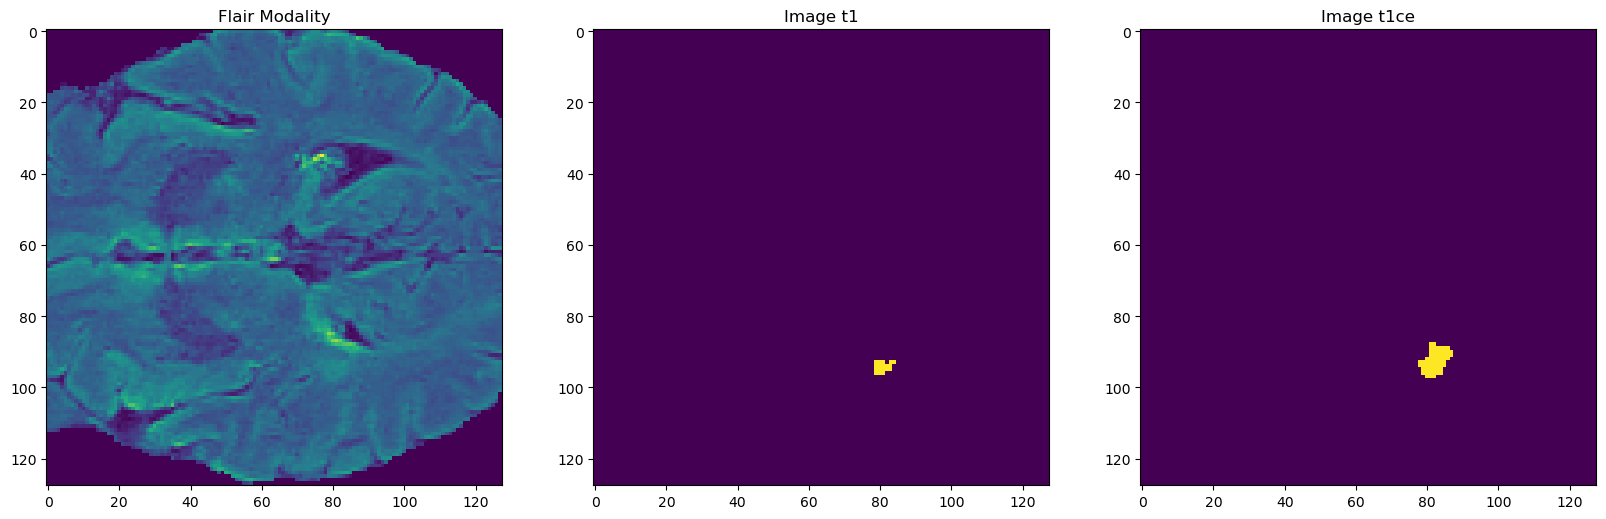

BraTS20_Training_166
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


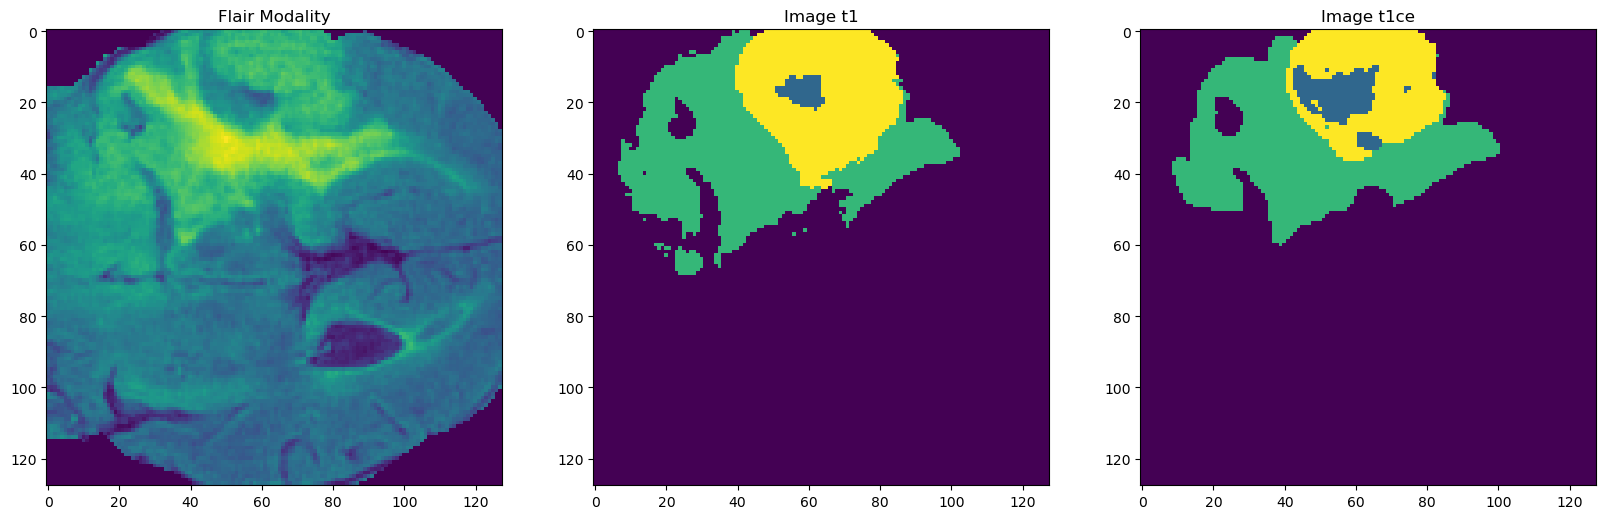

BraTS20_Training_114
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


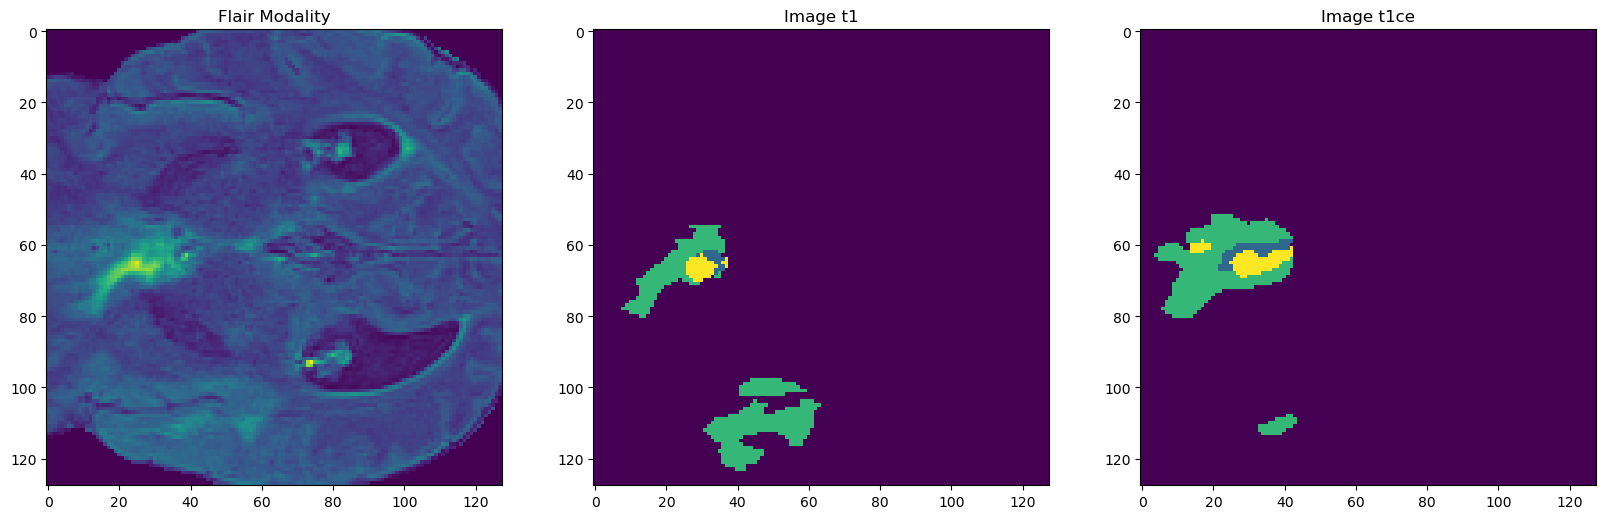

BraTS20_Training_111
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


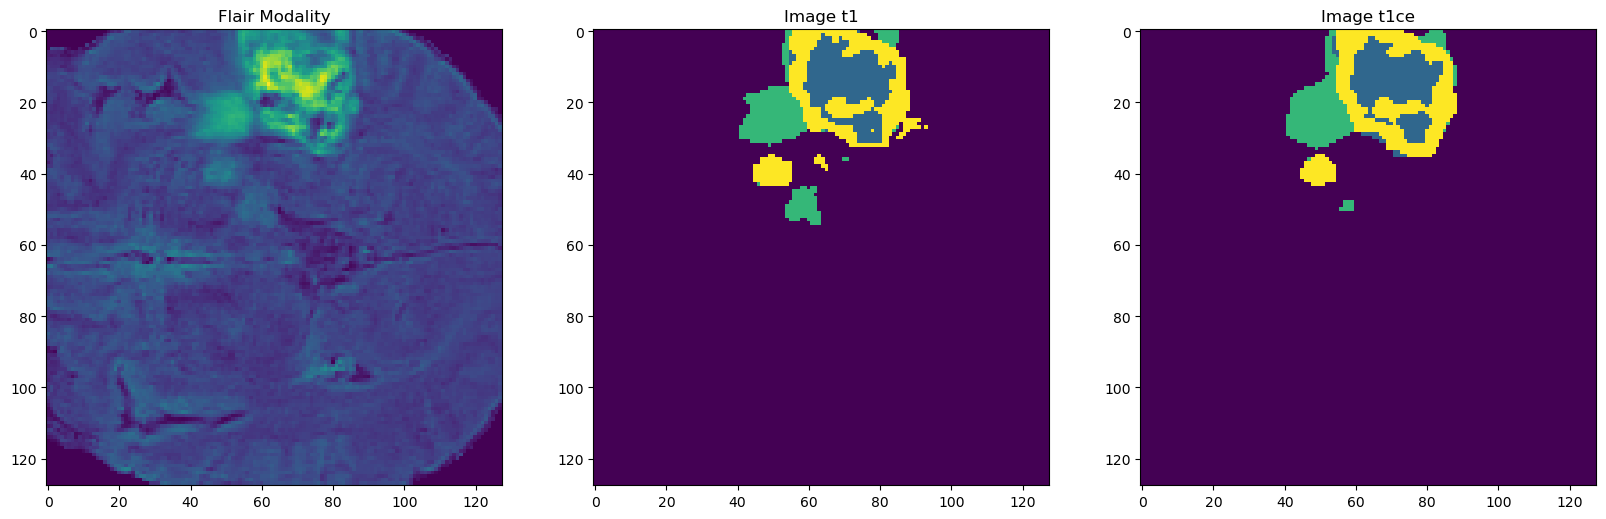

BraTS20_Training_153
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 64ms/step
(1, 128, 128, 128)


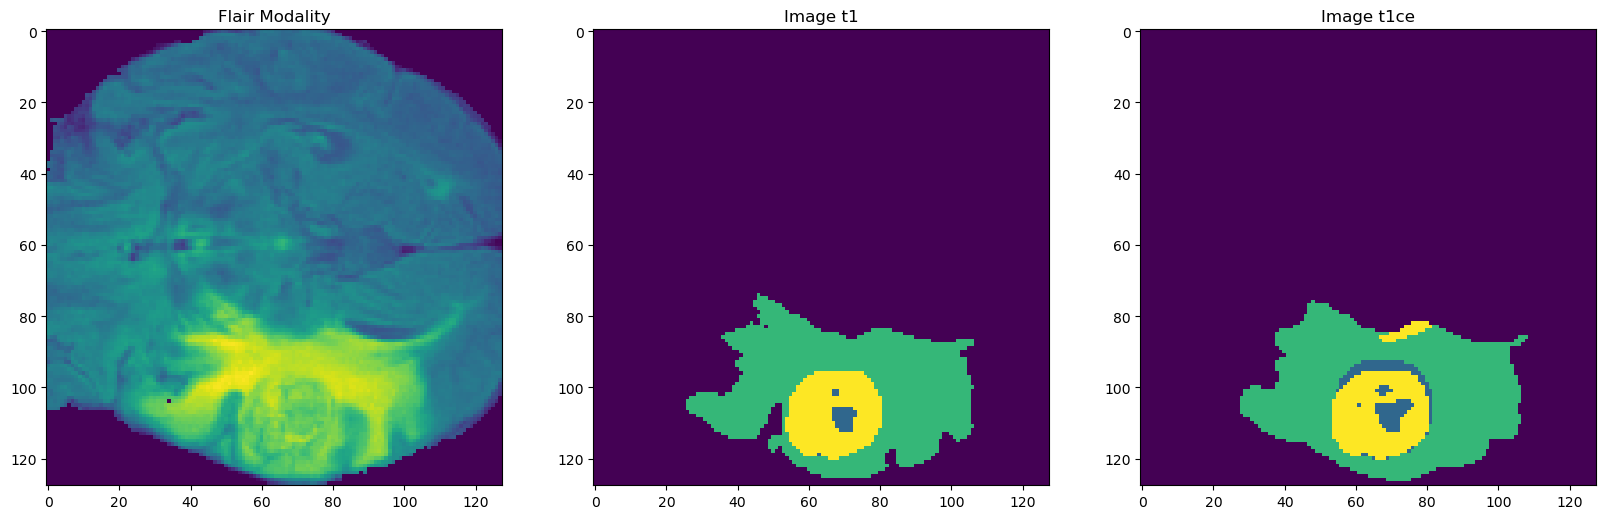

BraTS20_Training_202
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 62ms/step
(1, 128, 128, 128)


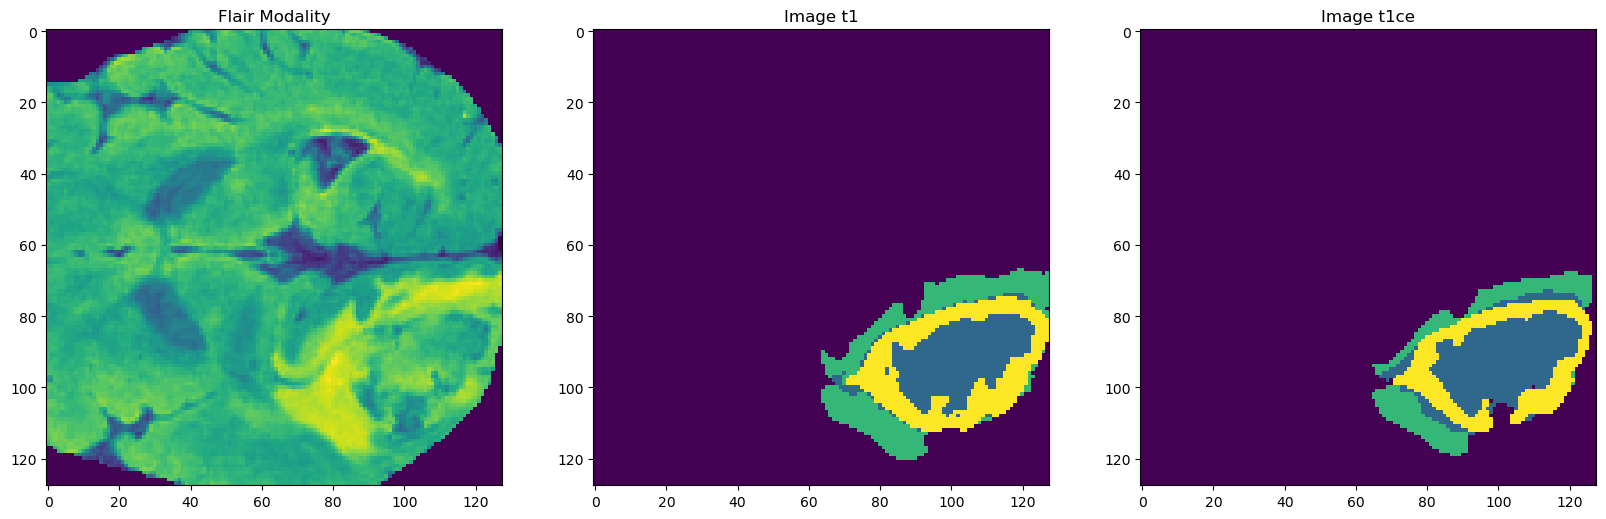

BraTS20_Training_247
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 66ms/step
(1, 128, 128, 128)


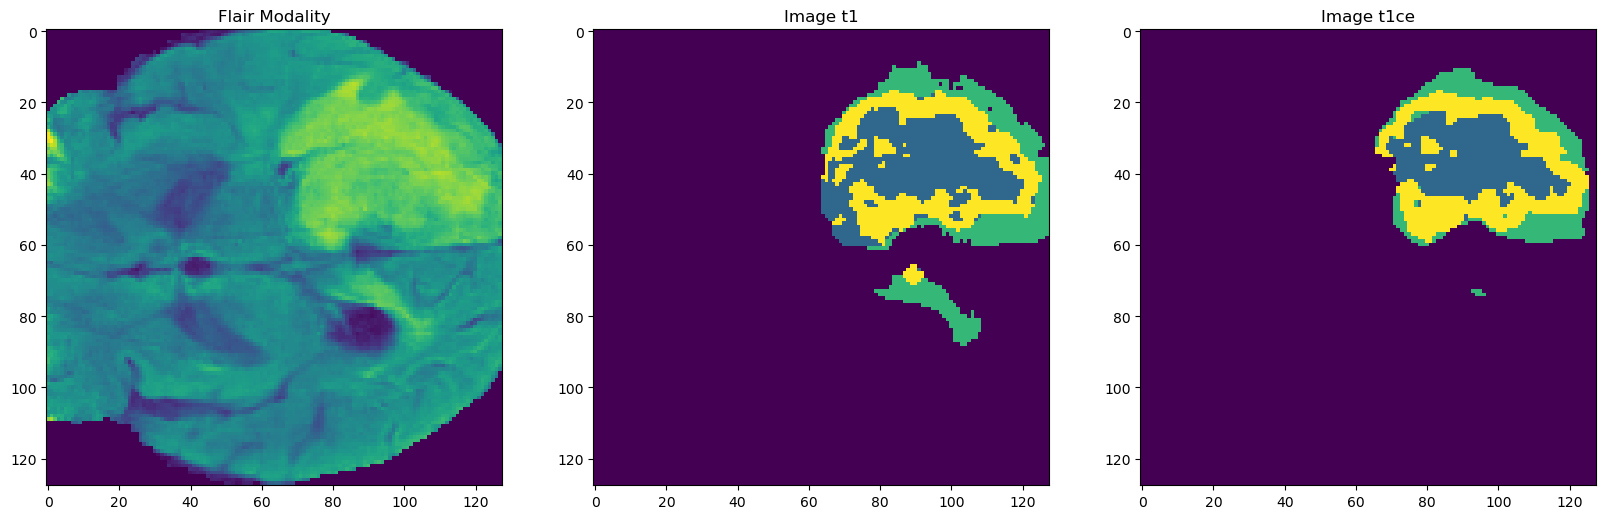

In [57]:
X2 = test_folders
lyst = ['073','166','114','111','153','202','247']


for x in lyst:
    predictByPath2("BraTS20_Training_"+x)
# plt.show()

BraTS20_Training_245
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 1s 553ms/step
(1, 128, 128, 128)


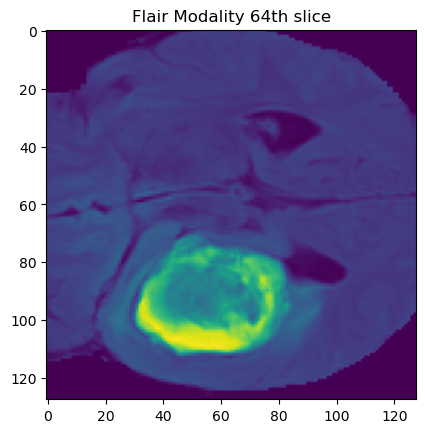

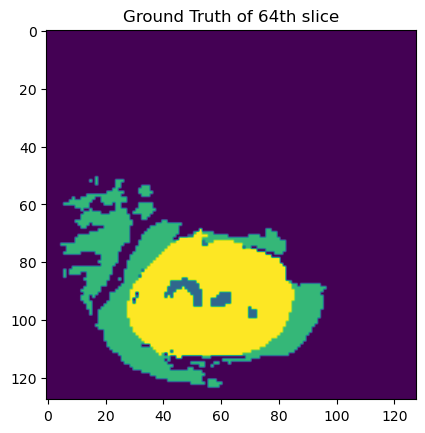

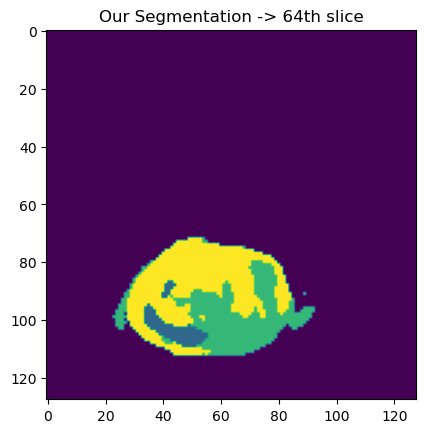

BraTS20_Training_073
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 63ms/step
(1, 128, 128, 128)


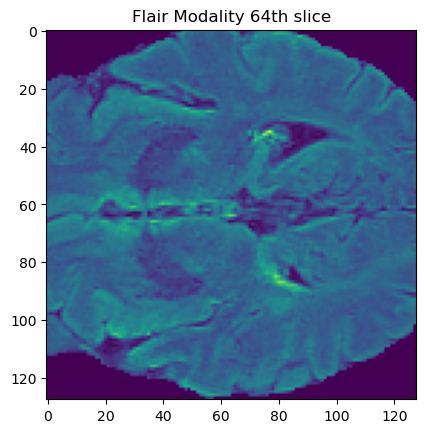

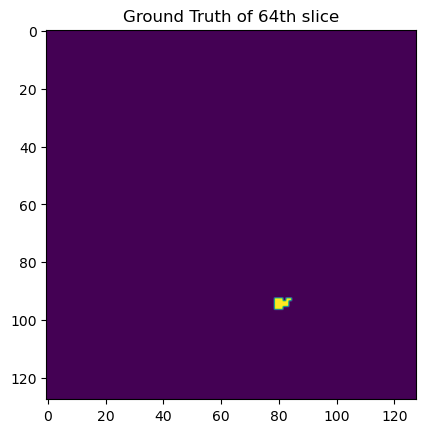

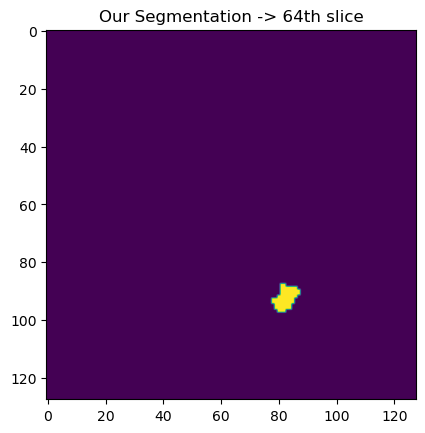

BraTS20_Training_341
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 60ms/step
(1, 128, 128, 128)


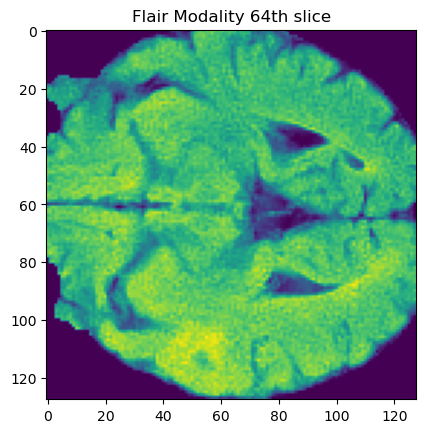

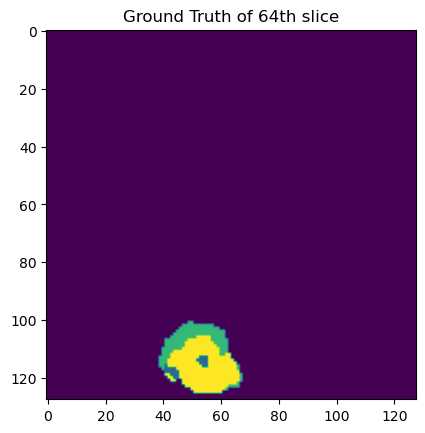

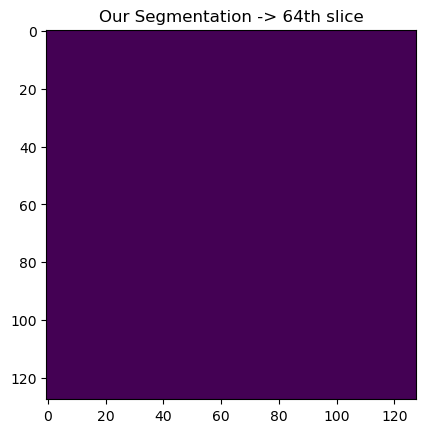

BraTS20_Training_310
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


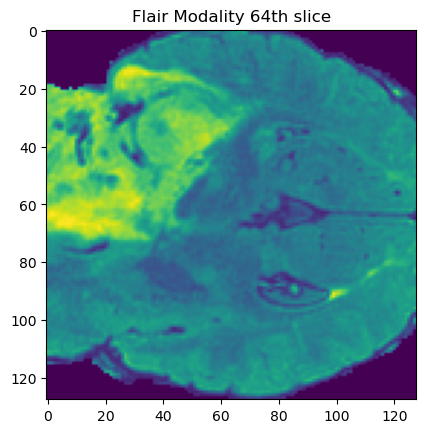

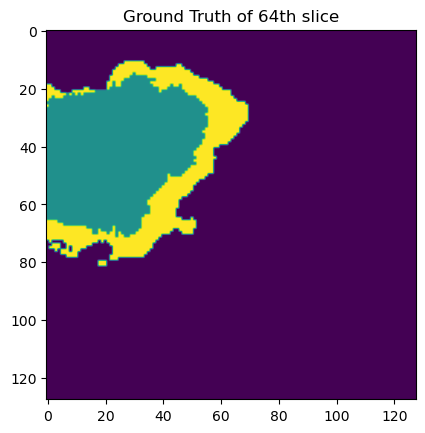

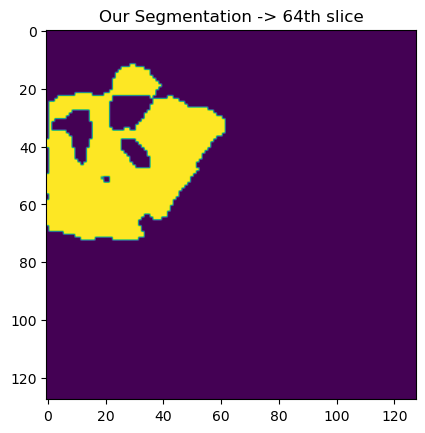

BraTS20_Training_166
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 63ms/step
(1, 128, 128, 128)


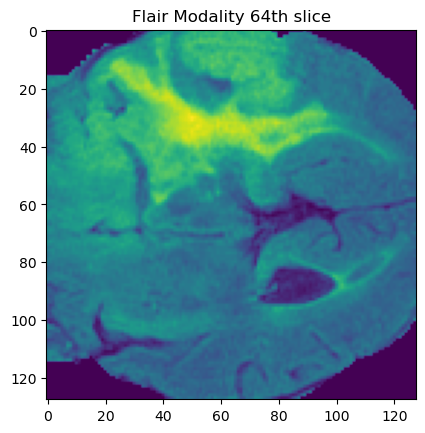

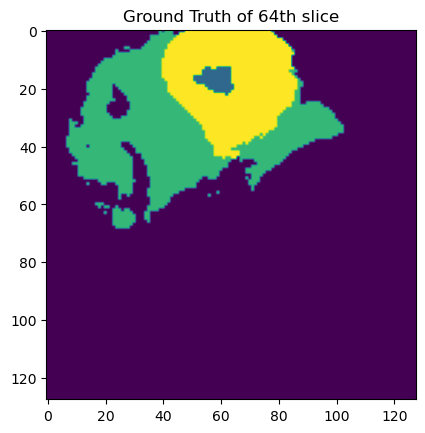

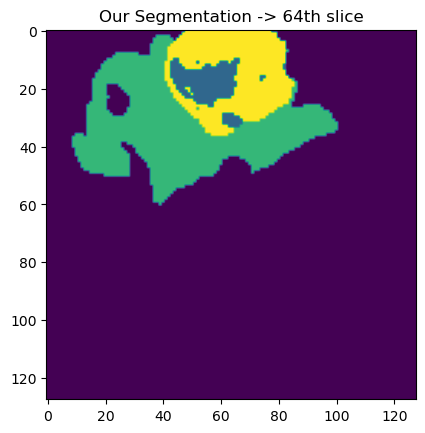

BraTS20_Training_238
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 64ms/step
(1, 128, 128, 128)


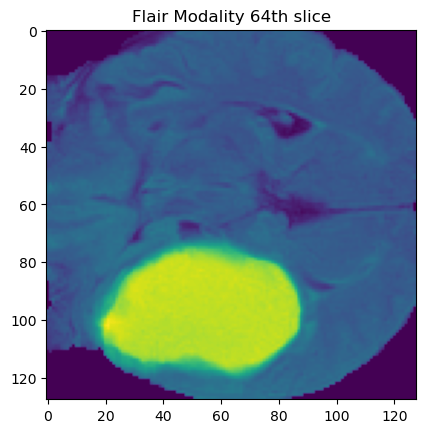

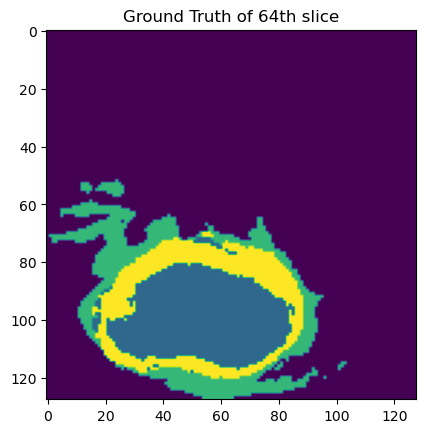

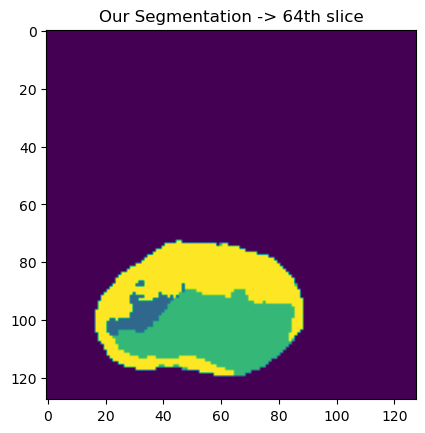

BraTS20_Training_176
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


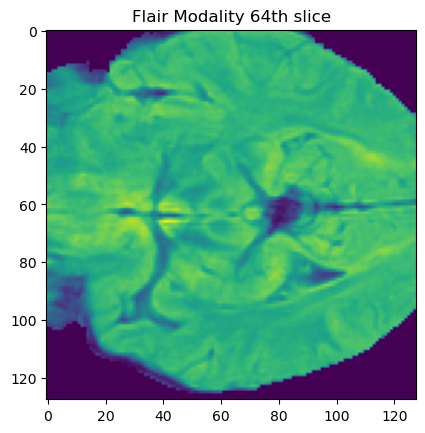

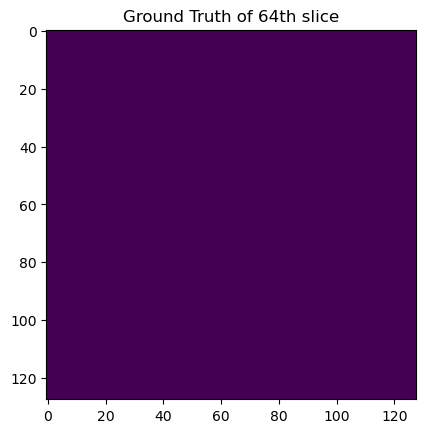

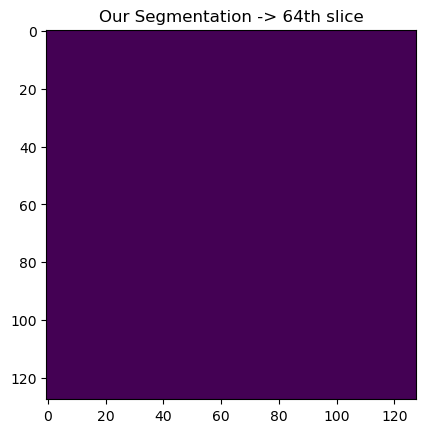

BraTS20_Training_125
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


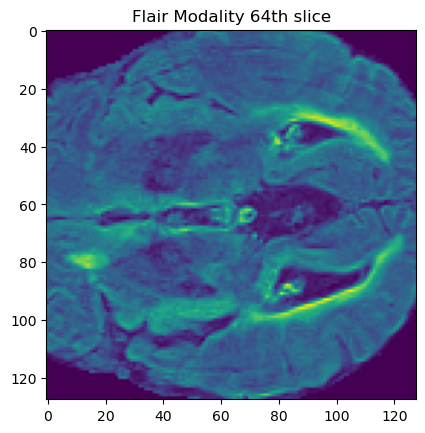

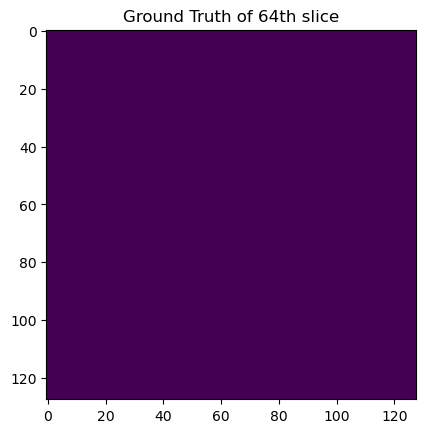

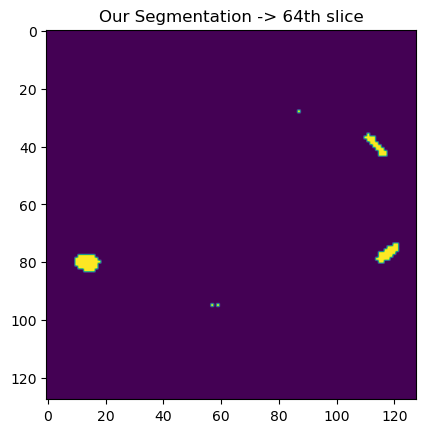

BraTS20_Training_230
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


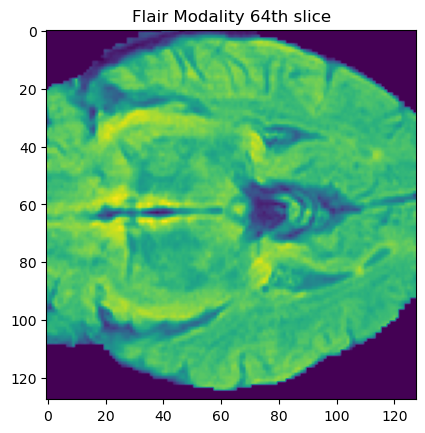

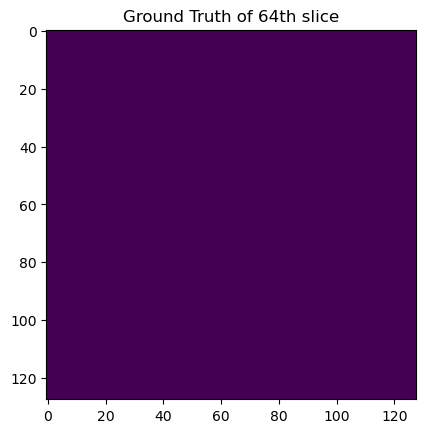

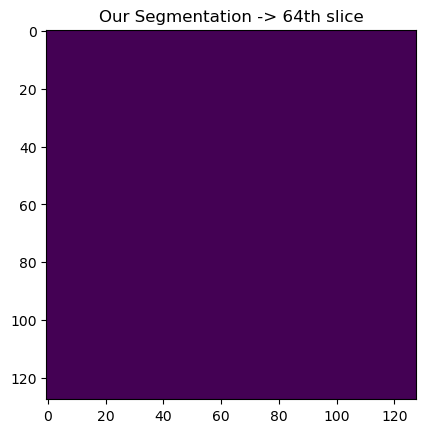

BraTS20_Training_110
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 69ms/step
(1, 128, 128, 128)


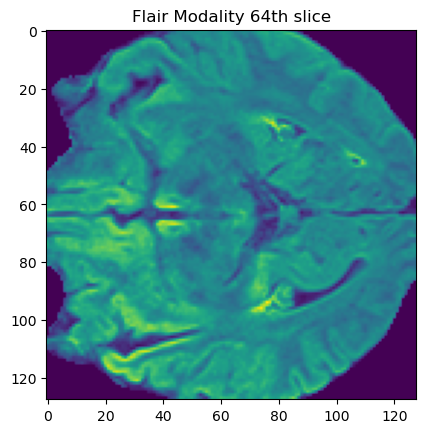

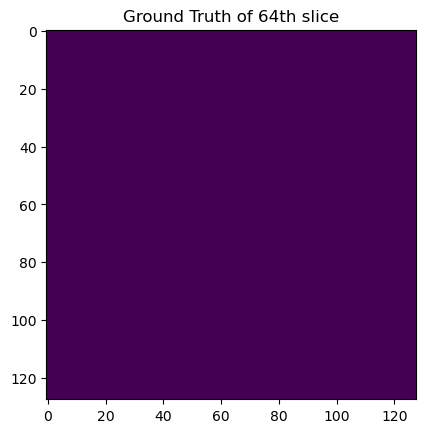

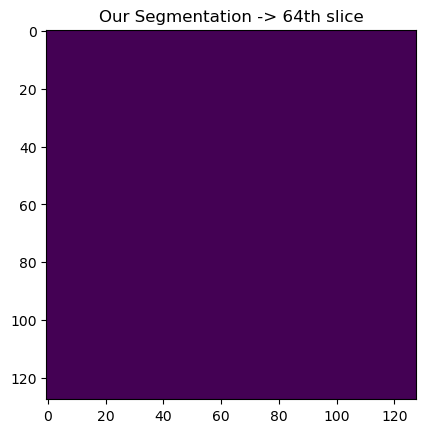

BraTS20_Training_114
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 64ms/step
(1, 128, 128, 128)


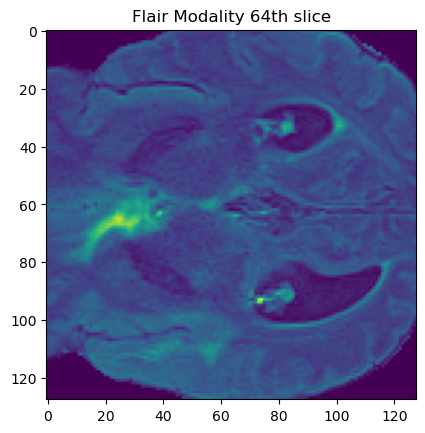

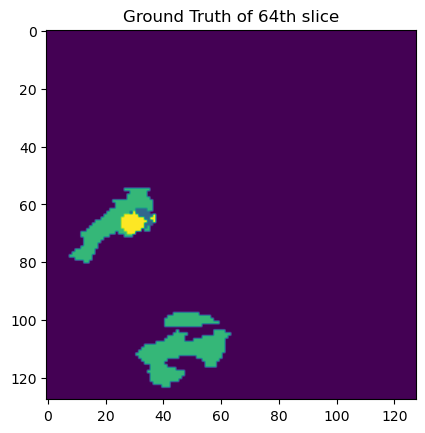

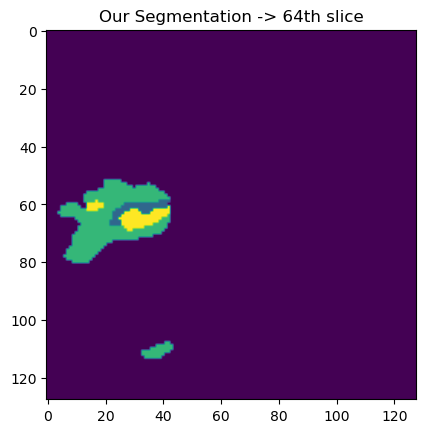

BraTS20_Training_115
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 63ms/step
(1, 128, 128, 128)


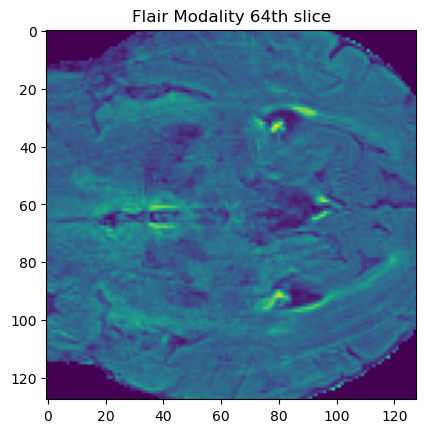

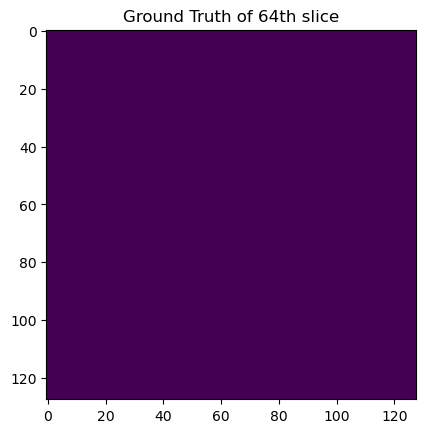

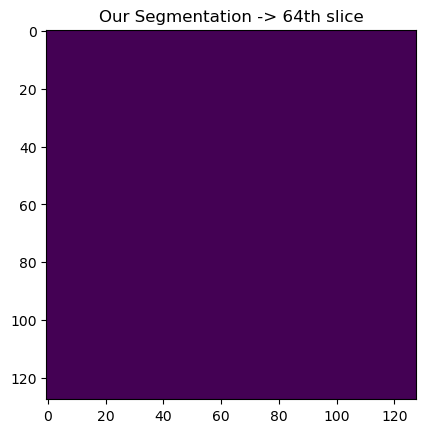

BraTS20_Training_111
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 63ms/step
(1, 128, 128, 128)


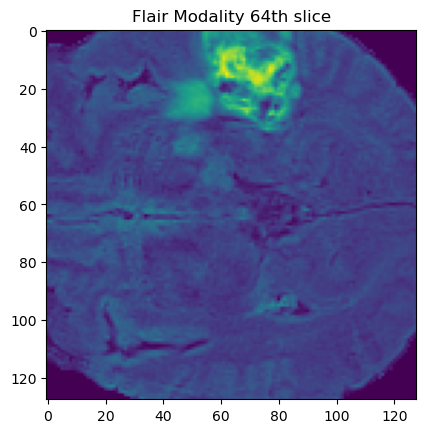

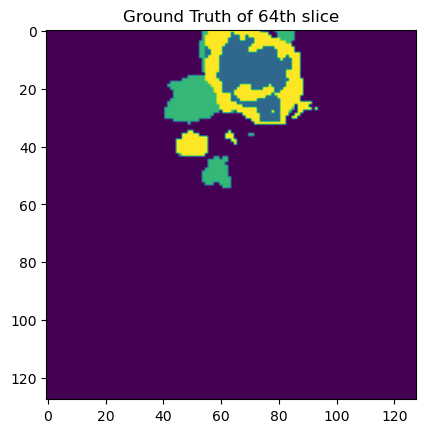

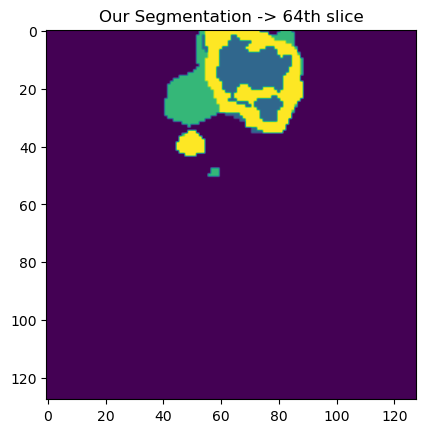

BraTS20_Training_079
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 65ms/step
(1, 128, 128, 128)


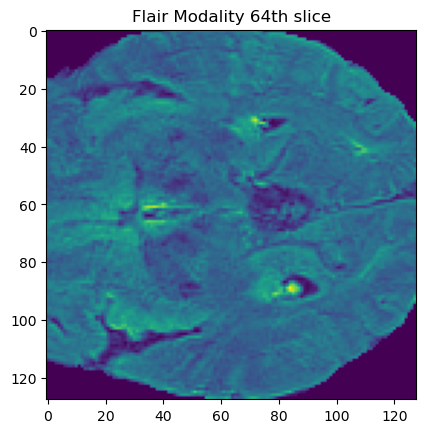

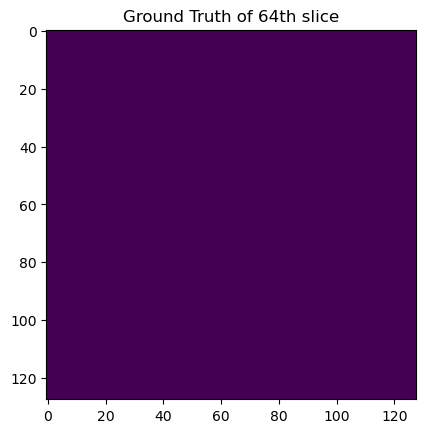

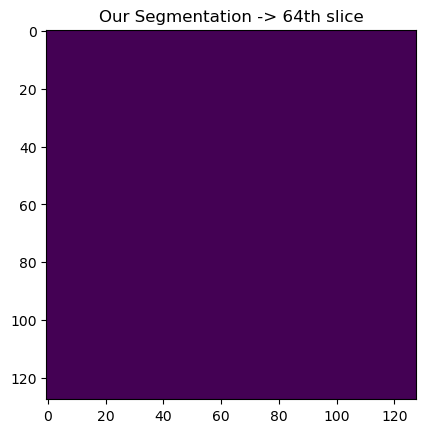

BraTS20_Training_153
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 61ms/step
(1, 128, 128, 128)


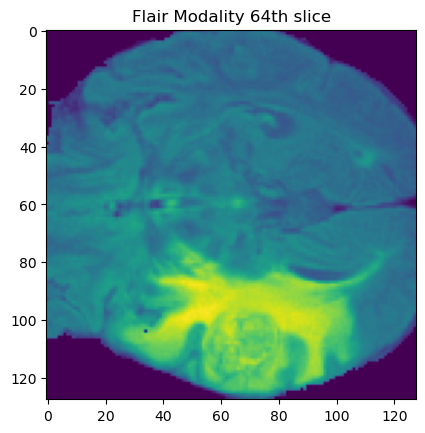

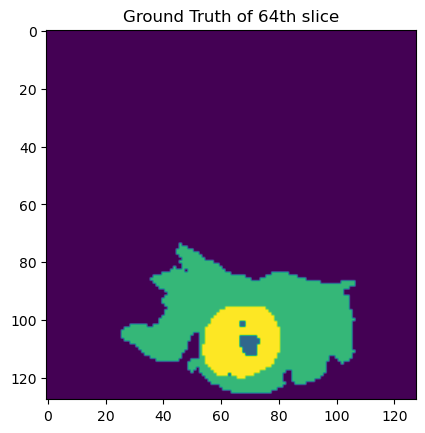

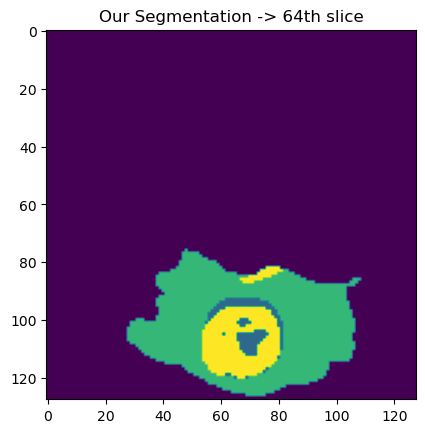

BraTS20_Training_058
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 62ms/step
(1, 128, 128, 128)


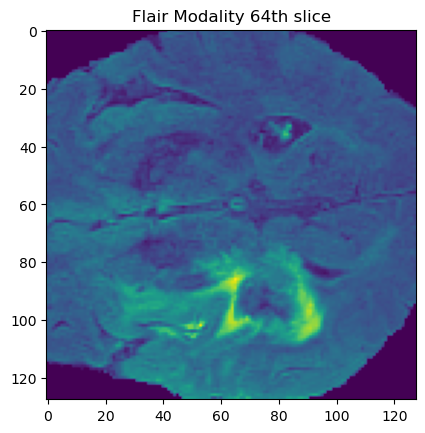

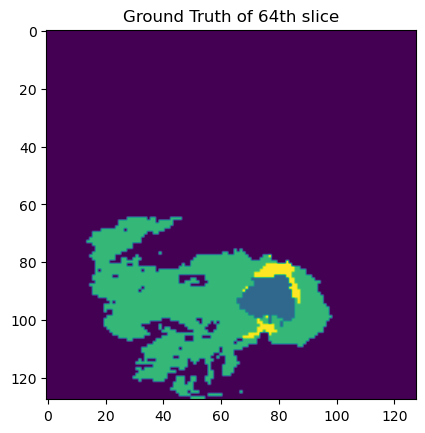

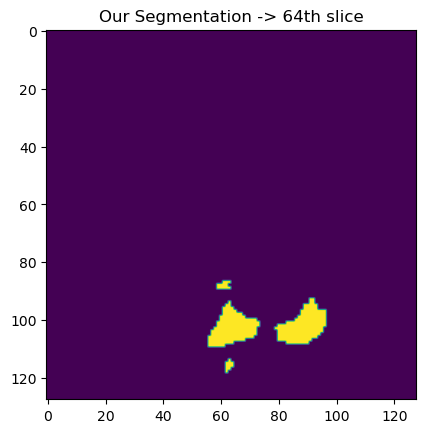

BraTS20_Training_333
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 62ms/step
(1, 128, 128, 128)


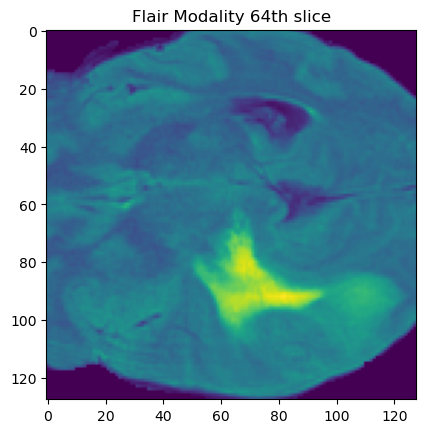

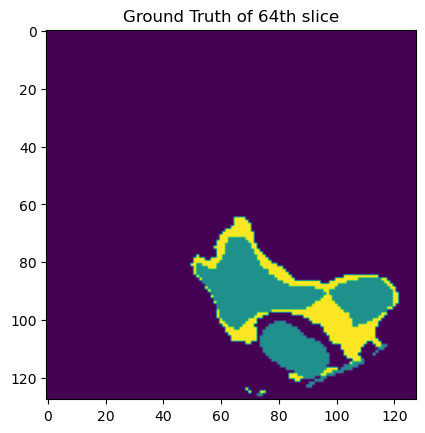

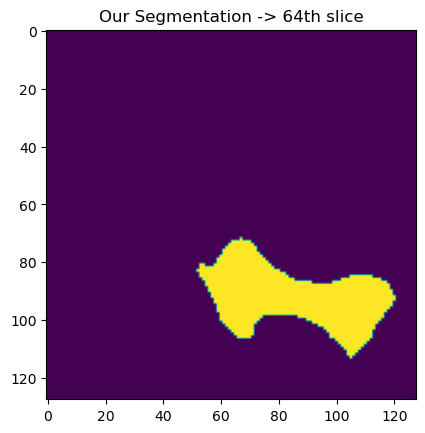

BraTS20_Training_342
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 62ms/step
(1, 128, 128, 128)


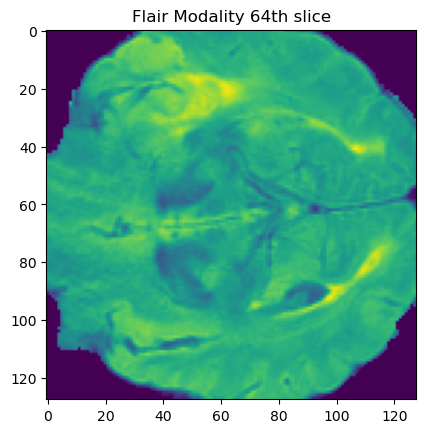

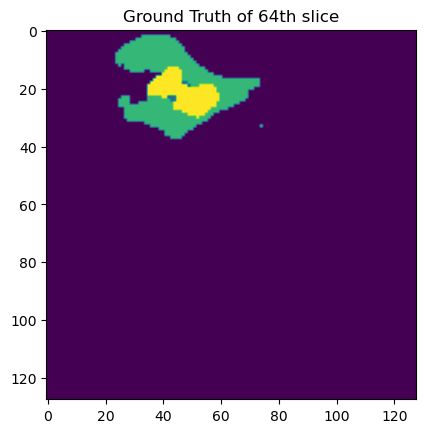

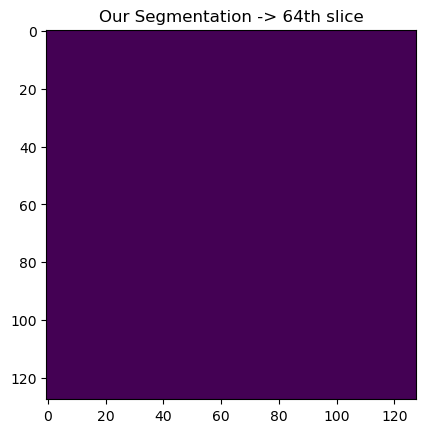

BraTS20_Training_046
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 42ms/step
(1, 128, 128, 128)


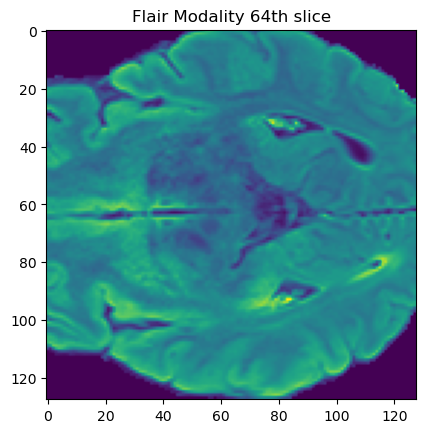

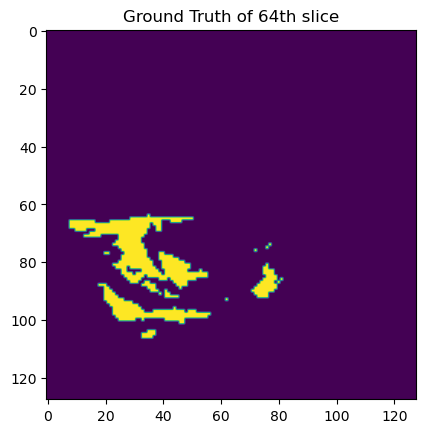

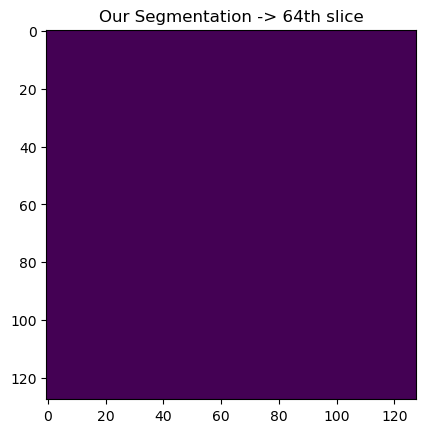

BraTS20_Training_074
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 65ms/step
(1, 128, 128, 128)


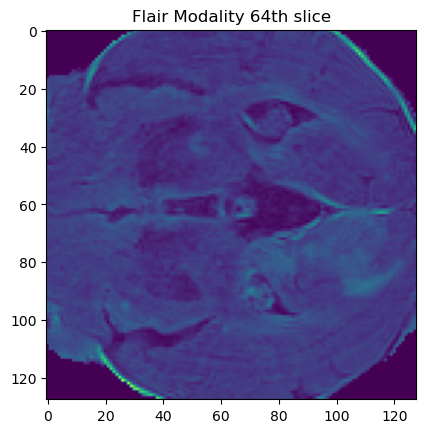

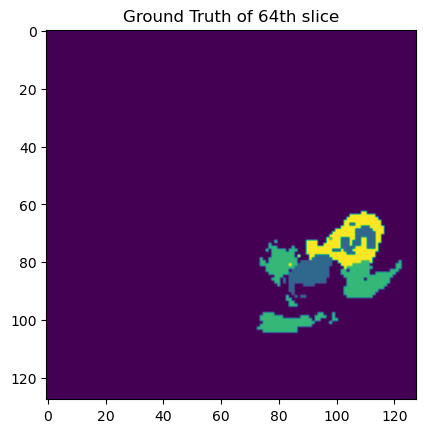

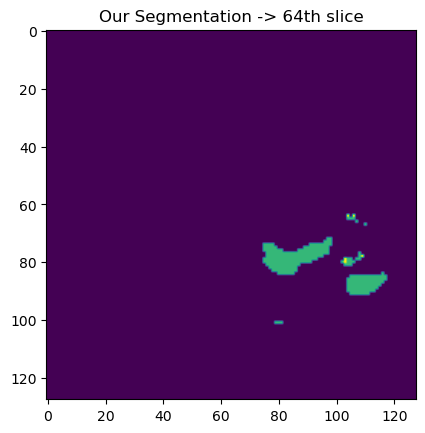

BraTS20_Training_203
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 62ms/step
(1, 128, 128, 128)


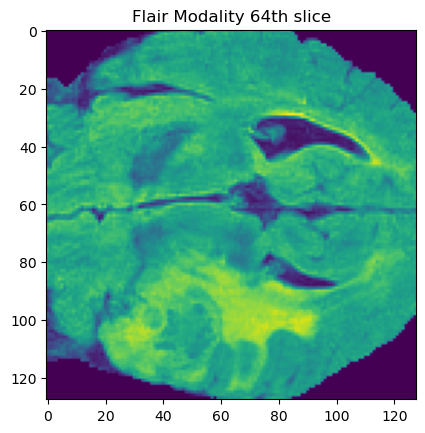

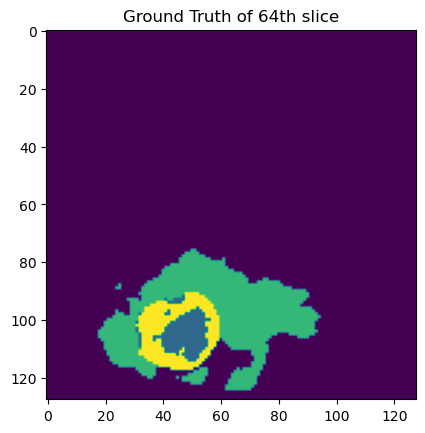

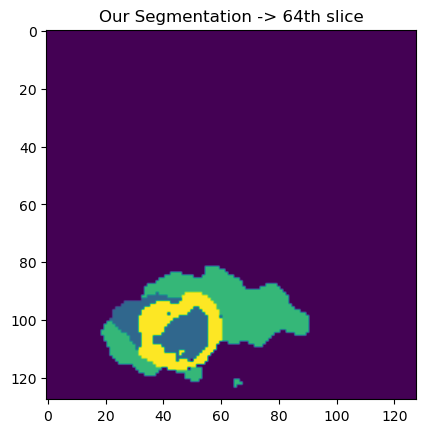

BraTS20_Training_247
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 43ms/step
(1, 128, 128, 128)


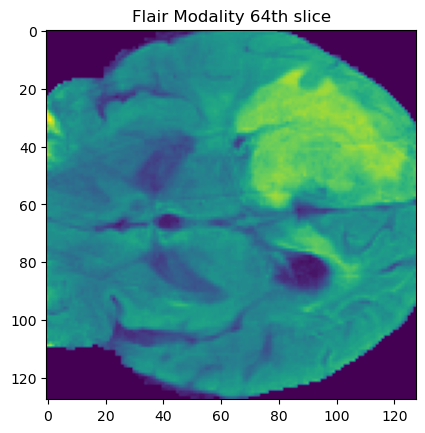

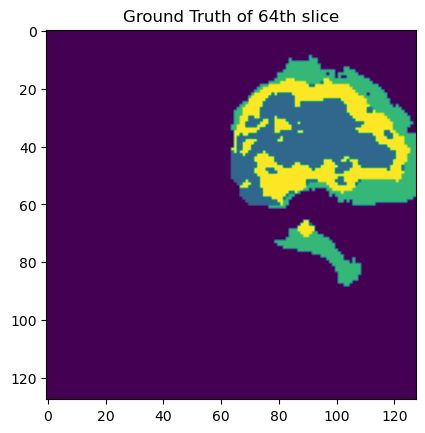

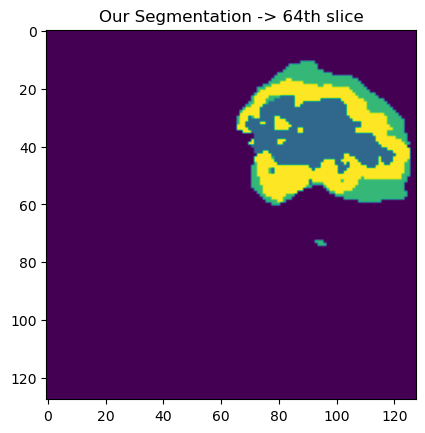

BraTS20_Training_358
Results on image number 201
Entered modality
Entered ground truth
Entered modality
Entered modality
Entered modality
(240, 240, 155, 4)
(240, 240, 155)
(1, 128, 128, 128)
(1, 128, 128, 128, 4)
(1, 128, 128, 128)
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 64ms/step
(1, 128, 128, 128)


In [ ]:
X = test_folders

for x in X:
    predictByPath(x)


In [ ]:
test_folders[:5]